In [39]:
import pandas as pd

import numpy as np
import scipy as sp
from scipy import signal
from scipy import ndimage
from scipy.ndimage.morphology import binary_closing
from scipy.optimize import curve_fit
from scipy.misc import imsave

import cv2
from PIL import ImageFilter
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops, label
from skimage.restoration import unwrap_phase
from skimage.feature import blob_log

import random
import os
import fnmatch
import math

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [40]:
#undefined: see https://docs.opencv.org/2.4/modules/highgui/doc/reading_and_writing_images_and_video.html#videocapture-get
CV_CAP_PROP_FRAME_HEIGHT = 4
CV_CAP_PROP_FRAME_WIDTH = 3
CV_CAP_PROP_FRAME_COUNT = 7
CV_CAP_PROP_FPS = 5

In [41]:
source_folders = []

source_folders.append(("data\\heparin\\2018.5.15\\prp1", "2018.5.15", 1800))
source_folders.append(("data\\heparin\\2018.5.15\\prp2", "2018.5.15", 3600))
source_folders.append(("data\\heparin\\2018.5.15\\prp3", "2018.5.15", 7200))
source_folders.append(("data\\heparin\\2018.6.1\\prp1", "2018.6.1", 1800))
source_folders.append(("data\\heparin\\2018.6.1\\prp2", "2018.6.1", 3600))
source_folders.append(("data\\heparin\\2018.6.1\\prp3", "2018.6.1", 7200))
source_folders.append(("data\\heparin\\2018.6.5\\prp1", "2018.6.5", 1800))
source_folders.append(("data\\heparin\\2018.6.5\\prp2", "2018.6.5", 3600))
source_folders.append(("data\\heparin\\2018.6.5\\prp3", "2018.6.5", 7200))
source_folders.append(("data\\heparin\\2018.6.6\\prp1", "2018.6.6", 1800))
source_folders.append(("data\\heparin\\2018.6.6\\prp2", "2018.6.6", 3600))
source_folders.append(("data\\heparin\\2018.6.6\\prp3", "2018.6.6", 7200))

img_path = "data\\heparin"

## Image Conversion

In [42]:
pp_path = "I:\\Honours-Project\\data\\pp.csv"
curve_path = "I:\\Honours-Project\\data\\curve.csv"

In [43]:
image_path = "I:\\Honours-Project\\data\\full trombus data\\agg\\0.tif"
#image_path = "I:\\Honours-Project\\data\\full trombus data\\agg\\fc2_save_2018-05-15-152139-0000.avi_frame75.jpg"
image_path = "I:\\Honours-Project\\data\\full trombus data\\agg\\c1.tif"
folder_path = "I:\\Honours-Project\\data\\full trombus data\\agg\\"

In [44]:
img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [45]:
cv2.imshow('image',gray)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [46]:
np.max(gray)

255

Source for block: https://stackoverflow.com/questions/17190649/how-to-obtain-a-gaussian-filter-in-python

In [47]:
def gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

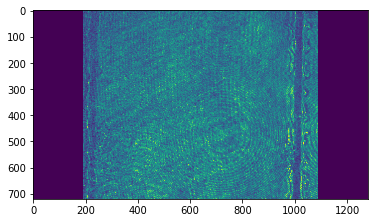

In [48]:
pil_im = Image.fromarray(np.uint8(gray))
plt.imshow(np.asarray(pil_im))

## Crop out walls

(720, 908)
14.623463683488644
103.57928750611846
91
784


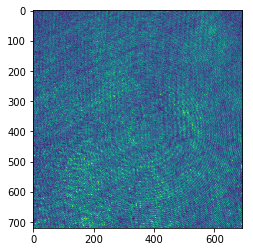

In [49]:
'''
    We assume that the walls are in the left and right most quadrant of the image, and a vertical stripes.
    We make no assumptions about the length of the wall
'''

def crop_border(img):
    
    #source: https://stackoverflow.com/questions/39465812/how-to-crop-zero-edges-of-a-numpy-array
    
    # argwhere will give you the coordinates of every non-zero point
    true_points = np.argwhere(img)
    # take the smallest points and use them as the top left of your crop
    top_left = true_points.min(axis=0)
    # take the largest points and use them as the bottom right of your crop
    bottom_right = true_points.max(axis=0)
    
    out = img[top_left[0]:bottom_right[0]+1,  # plus 1 because slice isn't
          top_left[1]:bottom_right[1]+1]  # inclusive
    
    return out

def crop_walls(img):
    img = crop_border(img)
    
    print(img.shape)
    
    level = threshold_otsu(img)
    
    left_quad = int(img.shape[1]/4)
    right_quad = img.shape[1]-left_quad
    
    img_sum = np.mean(img, axis=0)
    
    # Calculate a threshold for the wall
    thresh = np.mean(img_sum) - (np.std(img_sum))
    img_sum_mean = np.mean(img_sum)
    img_sum_std = np.std(img_sum)
    
    left_wall_pos = None
    right_wall_pos = None
    
    for i in range(left_quad):
        s = img_sum[left_quad-i]
            
        if s < thresh:
            left_wall_pos = left_quad-i + 30
            break
    
    for i in range(right_quad):
        s = img_sum[-(right_quad-i)]
        
        if s < thresh:
            right_wall_pos = img.shape[1] - right_quad+i - 30
            break
    
    print(np.std(img_sum))
    print(np.mean(img_sum))
    
    ostu = threshold_otsu(img_sum)
    
    print(left_wall_pos)
    print(right_wall_pos)
    
    pil_im = Image.fromarray(np.uint8(img[:,left_wall_pos:right_wall_pos]))
    plt.imshow(np.asarray(pil_im))
    
    #plt.bar(np.arange(len(img_sum)), img_sum > thresh)
    #plt.show()
    
    return img[:,left_wall_pos:right_wall_pos]
    
gray = crop_walls(gray)

Small Img
554
Big Img
79834
(720, 693)
(720, 693)
[444, 437, 276, 256]
[279, 267, 276, 256]


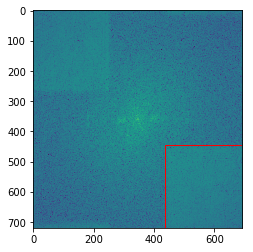

(-729065.3546928687-1502491.2469239442j)
(720, 693)


'pil_im = Image.fromarray(np.uint8(centeredfft))\nplt.imshow(np.asarray(pil_im))'

In [50]:
sigma=5

small_const = 30#25
large_const = 2.5 #2.5

def imgshapeiden(X, filterScaleFact):
    
    iy=1;  # number of objects
    inc=0; # thresholding increasement

    
    if len(X.shape) is not 2:
        raise Exception('Wrong frame shape, must be monochrome')
        
    size_x, size_y = X.shape
    ccdImfft = np.fft.fftshift(np.fft.fft2(X))
    
    # print(ccdImfft)
    
    fftMagIm = np.log(np.abs(ccdImfft)+1);
    fftMagIm = (fftMagIm - np.min(np.min(fftMagIm)))/(np.max(np.max(fftMagIm))-np.min(np.min(fftMagIm))); #Convert to range [0,1]

    # print("Gaus Test:")
    
    gauss = gauss2D((sigma*3+1,sigma*3+1),sigma)
    I_eq = np.flip(np.flip(sp.ndimage.correlate(fftMagIm, gauss, mode='constant'),0),1) # Source: https://stackoverflow.com/questions/22142369/the-equivalent-function-of-matlab-imfilter-in-python?rq=1
    #pil_im = Image.fromarray(np.uint8(fftMagIm))
    #I_eq = np.array(pil_im.filter(ImageFilter.GaussianBlur(sigma*3+1)))

    # print(I_eq.shape)
    # print(I_eq)
    
    small_img = round((size_x/small_const)*(size_y/small_const))
    big_img = round((size_x/large_const)*(size_y/large_const))
    
    print("Small Img")
    print(small_img)
    print("Big Img")
    print(big_img)
    
    level = threshold_otsu(I_eq)
    #level = 
    
    stp = level/100
        
    while iy is not 3:
        bw = I_eq >= level+inc    
        labelled = label(bw)
        bw4 = remove_small_objects(labelled, small_img, connectivity=8).astype(int)
        
        s = regionprops(bw4)
        iy = len(s)

        # We break if there are more than 3 images and none of them are bigger than big_img
        if iy == 3:
            area = [s[0].area, s[1].area, s[2].area]
            if max(area) > big_img:
                iy = 1
        
        inc = inc+stp

        if inc >= 1-level:
            centeredfft=None
            fftMagIm=None
            I3=None
            I5=None
            boundary=None
            return centeredfft,fftMagIm,I3,I5,boundary
        
    #print("Inc: ")    
    #print(inc)
    #print(level)
    
    #print(bw4)
    poz = []
    
    po1=s[0].centroid
    poz.append(abs(po1[0])+abs(po1[1]))
    #cen1=abs(abs(po1[0])-abs(po1[1]))
    po2=s[1].centroid
    poz.append(abs(po2[0])+abs(po2[1]))
    po3=s[2].centroid
    poz.append(abs(po3[0])+abs(po3[1]))
        
    which = poz.index(max(poz))
        
    boundingBox = list(s[which].bbox)
    boundingBox[2] = boundingBox[2]-boundingBox[0]
    boundingBox[3] = boundingBox[3]-boundingBox[1]
    #boundary = B{which}
    po=s[which].centroid
        
    halfx=abs(boundingBox[0]-po[0]) #Distance from centroid to start of bounding box
    halfy=abs(boundingBox[1]-po[1])
    halfacux=boundingBox[2]/2       
    halfacuy=boundingBox[3]/2
        
    if halfx>halfacux:
        boundingBox[2]= math.floor(halfx*2)
        boundingBox[2]= min(math.floor(halfx*2), ccdImfft.shape[0]-boundingBox[0])
    else:
        boundingBox[0]= math.floor(po[0]-halfx)
        boundingBox[0]= max(math.floor(po[0]-halfx), 0)
            
    if halfy>halfacuy:
        boundingBox[3]= math.floor(halfy*2) 
        boundingBox[3]= min(math.floor(halfy*2), ccdImfft.shape[1]-boundingBox[1])
    else:
        boundingBox[1]= math.floor(po[1]-halfy) 
        boundingBox[1]= max(math.floor(po[1]-halfy), 0)
        
    boundingBox = [boundingBox[0],boundingBox[1],fftMagIm.shape[0]-boundingBox[0],fftMagIm.shape[1]-boundingBox[1]]

    mask = np.zeros((size_x,size_y))
        
    mask[boundingBox[0]:boundingBox[0]+boundingBox[2],
            boundingBox[1]:boundingBox[1]+boundingBox[3]] = 1
        
    #I3 = np.dot(fftMagIm.transpose(),mask)
    #ccdImfft=np.dot(ccdImfft.transpose(),mask)
    
    #print(np.sum(ccdImfft))
    
    I3 = fftMagIm*mask
    ccdImfft=ccdImfft*mask
    centeredfft = np.zeros((size_x,size_y),dtype=complex)
    
    '''pil_im = Image.fromarray(np.uint8(mask))
    plt.imshow(np.asarray(pil_im))'''     
    #print(np.sum(ccdImfft))
    
    i,j = np.where(ccdImfft == np.max(ccdImfft))
    #print(i)
    #print(j)
    
    bb2 = boundingBox.copy()
    
    bb2[0] = int(round(size_x/2 - abs(po[0]-bb2[0]))) # Changed from y to x
    bb2[1] = int(round(size_y/2 - abs(po[1]-bb2[1]))) # Changed from x to y
    
    # bb2 = [301,123,52,77]
    
    Window = ccdImfft[boundingBox[0]:boundingBox[0]+boundingBox[2],
        boundingBox[1]:boundingBox[1]+boundingBox[3]]
    
    cfft_shape = centeredfft[bb2[0]:bb2[0]+bb2[2],bb2[1]:bb2[1]+bb2[3]].shape
    
    print(ccdImfft.shape)
    print(centeredfft.shape)
    print(boundingBox)
    print(bb2)
    
    centeredfft[bb2[0]:bb2[0]+bb2[2],bb2[1]:bb2[1]+bb2[3]] = Window
    # figure, imshow(I4)
    Window1 = I3[boundingBox[0]:boundingBox[0]+boundingBox[2], 
                 boundingBox[1]:boundingBox[1]+boundingBox[3]]
    I5=np.zeros((size_x,size_y))

    I5[bb2[0]:bb2[0]+bb2[2], bb2[1]:bb2[1]+bb2[3]] = Window1
    
    '''print(boundingBox)
    print(bb2)
    print(np.max(ccdImfft))
    print(Window)
    
    
    print(type(centeredfft))
    print(type(Window))'''
    
    
    pil_im = Image.fromarray(np.float64(fftMagIm))
    fig,ax = plt.subplots(1)
    ax.imshow(np.asarray(pil_im))
    rect = patches.Rectangle((boundingBox[1],boundingBox[0]),boundingBox[3],boundingBox[2],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    plt.show()
    
    return centeredfft,fftMagIm,I3,I5,None 
    #im = Image.fromarray(np.uint8(fftMagIm))
    #I_eq = im.filter(fspecial('gaussian',[sigma*3+1 sigma*3+1],sigma))

centeredfft, fftMagIm, I3, I5, o = imgshapeiden(gray,0.51)

print(np.sum(centeredfft)) 
print(centeredfft.shape)


'''pil_im = Image.fromarray(np.uint8(centeredfft))
plt.imshow(np.asarray(pil_im))'''   

In [51]:
def fit_func(data,a,b,c,d,e,f):
    l_x = len(data[:,0])
    l_y = len(data[0])
    
    y = data[0]
    x = np.repeat(range(1,l_x+1), l_y)
    y = np.tile(range(1,len(data[0])+1), ((l_x,1))).flatten()
    
    '''print("X: ")
    print(x)
    print(x.shape)
    print("Y: ")
    print(y)
    print(y.shape)'''
    
    f = a+b*x+c*y+d*x*y+e*np.power(x,2)+f*np.power(y,2)
    return f

def curve_removal(pp):
    x,y = pp.shape
    lin_x = np.linspace(1,x,x)
    lin_y = np.linspace(1,y,y)
    tile_x = np.tile(lin_y,(x,1))
    tile_y = np.tile(lin_x.transpose(),(y,1)).transpose()
    
    xy = np.tile(lin_x.flatten(),(y,1))
    z = pp.transpose().flatten()
    
    popt, pcov = curve_fit(fit_func,xy,z)
    
    '''print(tile_x)
    print(tile_y)
    
    print(tile_x.shape)
    print(tile_y.shape)
    print((tile_x*tile_y).shape)
    print(np.power(tile_y,2).shape)
    
    print("Popt")
    print(popt)
    print(pcov)
    
    print("PP shape")
    print(pp.shape)
    
    print("Z: ")
    print(z)'''
        
    return popt[0]+ popt[1]*tile_x+popt[2]*tile_y+popt[3]*tile_x*tile_y+popt[4]*np.power(tile_x,2)+popt[5]*np.power(tile_y,2)


Small Img
554
Big Img
79834
(720, 693)
(720, 693)
[444, 437, 276, 256]
[279, 267, 276, 256]


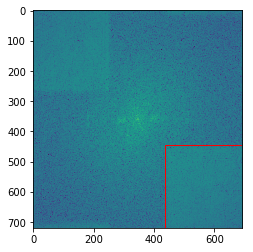

[[-448.43164658 -447.8659427  -447.61180242 ... -465.96802254
  -466.3391491  -467.2240433 ]
 [-448.91236711 -448.79380965 -448.58720605 ... -466.29086109
  -466.62068796 -467.0564111 ]
 [-448.66147573 -448.87998374 -448.90892976 ... -466.62520599
  -466.47538239 -466.52650182]
 ...
 [-378.83770505 -378.31765009 -388.98313265 ... -106.61390643
  -107.13212693 -108.13732116]
 [-380.13147416 -386.5515371  -387.67103758 ... -107.24341151
  -107.74398509 -108.70583953]
 [-387.66623986 -386.96420541 -387.00273714 ... -107.8854952
  -108.43784476 -109.35470564]]


(array([[246.87357264, 246.13498467, 245.08794591, ...,  53.8721132 ,
          54.28539554,  54.18802305],
        [244.98461651, 243.79851087, 242.70356419, ...,  51.89193758,
          52.34614837,  52.6975757 ],
        [243.83010036, 242.306558  , 240.97569046, ...,  49.90308366,
          50.83657369,  51.5722335 ],
        ...,
        [ 21.45383076,  20.41046893,   8.18468241, ..., -55.66027723,
         -55.65321375, -56.13001119],
        [ 20.72581389,  12.74196293,  10.06178725, ..., -55.97313152,
         -55.94879237, -56.38262124],
        [ 13.75962851,  12.8975037 ,  11.29792553, ..., -56.29573636,
         -56.32354442, -56.71275098]]),
 array([[0.36450789, 1.65600458, 1.97402357, ..., 5.47347965, 3.39802333,
         2.66138464],
        [1.39293361, 2.09880188, 2.07040111, ..., 6.13177107, 5.6311127 ,
         4.90258702],
        [1.91254529, 2.55694497, 2.95766203, ..., 5.0546419 , 4.65588155,
         3.02854149],
        ...,
        [4.12201366, 4.18195329, 1.8

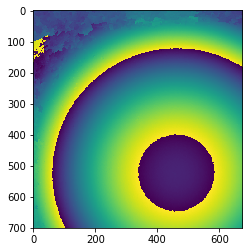

In [52]:
pp = None

def ip_single_hologram(frame,curve):
    cut = 10
    filterScaleFact = 0.51
    
    if len(frame.shape) is not 2:
        raise Exception('Wrong frame shape, must be monochrome')
    size_x, size_y = frame.shape
    
    centeredfft_sample, I2, I3, I4, boundary = imgshapeiden(frame,filterScaleFact)
        
    if centeredfft_sample is None:
        return None,None,None
    
    #Show image:
    
    #ifft
    centeredImage_s = np.fft.ifft2(np.fft.fftshift(centeredfft_sample))
    f = np.angle(centeredImage_s)
    intensity=np.abs(centeredImage_s)
    pp = unwrap_phase(f)
    pp = pp[cut-1:size_x-cut,cut-1:size_y-cut]
    
    print(pp)
    
    pil_im = Image.fromarray(np.uint8(pp))
    plt.imshow(np.asarray(pil_im))
        
    if np.sum(curve) == 0:
        curve=curve_removal(pp)
        
    #curve = pd.read_csv(curve_path, header=None).as_matrix()
    #pp = pd.read_csv(pp_path, header=None).as_matrix()

    intensity=intensity[cut-1:size_x-cut,cut-1:size_y-cut]
    phase=pp -curve
    
    '''print("Centered Image:")
    print(centeredImage_s)
    print("Centered fft Sample: ")
    print(np.sum(centeredfft_sample))
    print(curve)
    print(pp)
    print(np.sum(phase))'''
    
    return phase,intensity,curve

ip_single_hologram(gray,0)

(720, 908)
14.623463683488644
103.57928750611846
91
784
Small Img
554
Big Img
79834
(720, 693)
(720, 693)
[444, 437, 276, 256]
[279, 267, 276, 256]


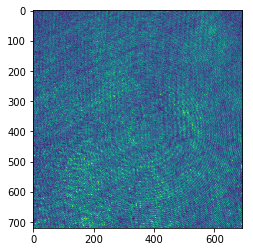

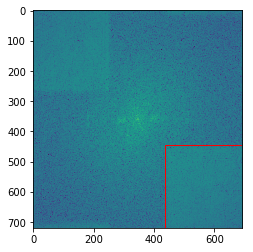

[[-448.43164658 -447.8659427  -447.61180242 ... -465.96802254
  -466.3391491  -467.2240433 ]
 [-448.91236711 -448.79380965 -448.58720605 ... -466.29086109
  -466.62068796 -467.0564111 ]
 [-448.66147573 -448.87998374 -448.90892976 ... -466.62520599
  -466.47538239 -466.52650182]
 ...
 [-378.83770505 -378.31765009 -388.98313265 ... -106.61390643
  -107.13212693 -108.13732116]
 [-380.13147416 -386.5515371  -387.67103758 ... -107.24341151
  -107.74398509 -108.70583953]
 [-387.66623986 -386.96420541 -387.00273714 ... -107.8854952
  -108.43784476 -109.35470564]]


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\skimage\morphology\misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


array([[ 91.12042435, 117.18567284, 140.2827925 , ...,  33.27806491,
         29.40565509,  24.5750189 ],
       [117.11148133, 150.60935791, 180.29366829, ...,  42.05698373,
         37.17113361,  31.07256265],
       [140.10604616, 180.18219124, 215.69744648, ...,  49.282117  ,
         43.56407614,  36.41800669],
       ...,
       [ 10.99779541,  13.75651242,  16.19318704, ...,   0.        ,
          0.        ,   0.        ],
       [  9.4311273 ,  11.85522723,  14.01316783, ...,   0.        ,
          0.        ,   0.        ],
       [  7.63816369,   9.65265716,  11.46418326, ...,   0.        ,
          0.        ,   0.        ]])

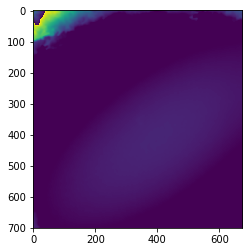

In [53]:
dx=0.424
dy=0.424
dz=1.503

def convert_to_heightmap_from_path(path):
    img = cv2.imread(path)
    
    return convert_to_heightmap(img)

def convert_to_heightmap(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = crop_walls(gray)
    
    phase, intensity, curve = ip_single_hologram(gray,0)
    height = phase*dz
    
    #print(height)
    
    gauss = gauss2D((3*3+1,3*3+1),3)
    height_s = sp.ndimage.correlate(height, gauss, mode='constant') # Source: https://stackoverflow.com/questions/22142369/the-equivalent-function-of-matlab-imfilter-in-python?rq=1
    #height_s = np.flip(np.flip(sp.ndimage.correlate(height, gauss, mode='constant'),0),1)
    
    #print("Height S: ")
    #print(height_s)
    
    img_x, img_y = phase.shape
    
    height_r = height_s.copy()
    height_r[height_r < 0] = 0
    s_areatotal= img_x*img_y*dx*dy
    
    level = threshold_otsu(height_r)
    bw1 = height_r >= level
    
    #B = bwboundaries(bw1);
    
    smalls=round(math.sqrt(img_x*img_y)/40)
    bigs=round((img_x*img_y)/30)
    
    se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(smalls,smalls))
    bw2 = binary_closing(bw1, se)
    
    labelled = label(bw2)
    bw3 = remove_small_objects(labelled, bigs, connectivity=8)
    
    s = regionprops(bw3)
    
    #B = bwboundaries(bw3);
    height_remove= height_s*bw3
    
    count = len(s)
    
    #if count != 0:
    #    for m in range(count):
            
    '''print(height_r)
    print(np.sum(phase))
    print(height_s.shape)
    print(bw3.shape)
    print(height_remove.shape)
    print(s_areatotal)
    print(level)'''
    
    pil_im = Image.fromarray(np.uint8(height_r))
    plt.imshow(np.asarray(pil_im)) 
    
    return height_r
    
    '''pil_im.save('out.bmp')'''
convert_to_heightmap_from_path(image_path)

Small Img
537
Big Img
53710
(657, 327)
(657, 327)
[429, 207, 51, 75]
[304, 126, 51, 75]


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\skimage\morphology\misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


[[-5.91318406 -5.85563076 -5.75102967 ... 26.83037073 26.89679134
  26.95179694]
 [-5.92845154 -5.8656609  -5.75344212 ... 26.79183679 26.87181537
  26.93589682]
 [-5.95056161 -5.88232444 -5.76289897 ... 26.73967053 26.837105
  26.91318533]
 ...
 [16.83022332 16.90238875 16.95288387 ... 49.26106375 49.29176069
  49.31760975]
 [16.96384582 17.06128065 17.13205882 ... 49.33144414 49.35325366
  49.37107453]
 [17.09968716 17.22373908 17.31388541 ... 49.41413219 49.43067999
  49.44702606]]
<class 'numpy.ndarray'>


C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """


Small Img
167
Big Img
16689
(277, 241)
(277, 241)
[170, 153, 41, 51]
[119, 95, 41, 51]
[[-13.17325376 -12.97011642 -12.71248888 ...  21.46361949  21.64649198
   21.9363983 ]
 [-13.18337404 -12.96867202 -12.70739957 ...  21.50051799  21.68672719
   21.95516561]
 [-13.16804945 -12.94906005 -12.70252731 ...  21.53476085  21.73754253
   22.00332053]
 ...
 [ -3.44819944  -3.39857559  -3.38147814 ...  30.3474793   30.7192103
   31.12216112]
 [ -3.3993759   -3.33155699  -3.29662499 ...  30.47934574  30.91421435
   31.32168956]
 [ -3.33986596  -3.25909814  -3.21043589 ...  30.61919437  31.11106307
   31.51887449]]
<class 'numpy.ndarray'>
Small Img
283
Big Img
28268
(382, 296)
(382, 296)
[251, 198, 30, 34]
[178, 133, 30, 34]
[[-26.36688566 -26.32056946 -26.28935494 ...   5.25771538   5.41959534
    5.59715793]
 [-26.34961564 -26.30504555 -26.27400883 ...   5.27807163   5.43463755
    5.60630465]
 [-26.33074066 -26.28848335 -26.25790895 ...   5.30392463   5.45551144
    5.62149691]
 ...
 [  2.93

Small Img
116
Big Img
11650
(200, 233)
(200, 233)
[119, 150, 26, 36]
[88, 98, 26, 36]
[[-22.13843138 -22.13294262 -22.10575247 ...  -7.70573268  -7.59484199
   -7.46108708]
 [-22.06588022 -22.0768258  -22.06124874 ...  -7.65420633  -7.55056992
   -7.42734281]
 [-21.99429211 -22.02048514 -22.01561767 ...  -7.59641147  -7.50061049
   -7.38843383]
 ...
 [ -5.99256963  -6.01028152  -6.02223732 ...   7.88987624   8.01609186
    8.17801136]
 [ -5.86433519  -5.83577804  -5.79162788 ...   8.02116046   8.14180494
    8.29937217]
 [ -5.71567073  -5.62836891  -5.5204627  ...   8.1458291    8.26228651
    8.41758029]]
<class 'numpy.ndarray'>
Small Img
265
Big Img
26549
(389, 273)
(389, 273)
[227, 176, 60, 60]
[166, 106, 60, 60]
[[-2.54210968 -2.56899977 -2.60249335 ...  9.0618      9.16030338
   9.16438228]
 [-2.55819022 -2.58761326 -2.62570309 ...  9.05789413  9.17128433
   9.18016822]
 [-2.56689684 -2.59633513 -2.63784501 ...  9.0553746   9.19507436
   9.21279143]
 ...
 [ 6.44834062  6.45060926 

<class 'numpy.ndarray'>
Small Img
367
Big Img
36682
(411, 357)
(411, 357)
[240, 232, 61, 73]
[175, 142, 61, 73]
[[-2.48532744 -2.41355282 -2.38904191 ... 18.33112736 18.76054452
  19.35845167]
 [-2.5199259  -2.45525641 -2.43761428 ... 18.59817657 19.1193398
  19.70708015]
 [-2.55279044 -2.49699019 -2.48856512 ... 18.9725232  19.50593171
  20.02054354]
 ...
 [20.8749459  20.89226297 20.83596473 ... 38.9673982  38.9115609
  38.88302274]
 [20.82478073 20.82515522 20.78090932 ... 39.11395444 39.03483657
  38.99710455]
 [20.76872121 20.74299575 20.70352345 ... 39.27615921 39.19380566
  39.15935687]]
<class 'numpy.ndarray'>
Small Img
132
Big Img
13162
(234, 225)
(234, 225)
[140, 144, 31, 38]
[102, 94, 31, 38]
[[-15.4025147  -15.37625522 -15.31766893 ...   1.69861924   1.78304919
    1.85909319]
 [-15.41012889 -15.39351947 -15.33130335 ...   1.70455451   1.79714366
    1.8891943 ]
 [-15.41792885 -15.413655   -15.35098538 ...   1.7158281    1.81733718
    1.92696466]
 ...
 [ -1.69775949  -1.79

[[-0.14643202 -0.13182531 -0.15446405 ...  3.96722164  4.05730017
   4.16405768]
 [-0.09238116 -0.08991177 -0.13195453 ...  3.95755339  4.0540723
   4.16633859]
 [-0.07397491 -0.08094492 -0.13944546 ...  3.95302126  4.05628998
   4.17268429]
 ...
 [14.46210227 14.40139607 14.3733278  ... 19.6018285  19.6624092
  19.71420884]
 [14.62893464 14.57517331 14.54523546 ... 19.71791545 19.75776013
  19.79458312]
 [14.77899767 14.73705337 14.71045867 ... 19.81147098 19.8413246
  19.87236428]]
<class 'numpy.ndarray'>
Small Img
81
Big Img
8149
(205, 159)
(205, 159)
[118, 106, 26, 31]
[90, 64, 26, 31]
[[-0.5344521  -0.59301445 -0.6602082  ... -1.80504078 -1.7892091
  -1.76795925]
 [-0.54230183 -0.60383967 -0.67546674 ... -1.78451925 -1.7648041
  -1.73927186]
 [-0.5457493  -0.61129443 -0.68913876 ... -1.7642042  -1.73614902
  -1.69982589]
 ...
 [ 4.90166814  4.82912471  4.80178081 ...  4.76355632  4.71023795
   4.68516226]
 [ 4.95076699  4.87487785  4.84639115 ...  4.78097903  4.73096606
   4.70783

<class 'numpy.ndarray'>
Small Img
153
Big Img
15262
(233, 262)
(233, 262)
[153, 187, 20, 27]
[106, 118, 20, 27]
[[ 0.27892542  0.27445861  0.25967957 ... 14.06987077 14.37875849
  14.7505525 ]
 [ 0.25443703  0.25461777  0.24554677 ... 14.04175979 14.33525467
  14.6972402 ]
 [ 0.22591489  0.23037774  0.22669395 ... 14.01901493 14.29845423
  14.65042896]
 ...
 [ 4.28818925  4.27412218  4.25628849 ... 18.02808919 18.48131007
  19.01396987]
 [ 4.33931338  4.32798613  4.31304434 ... 18.01280344 18.4368532
  18.96400315]
 [ 4.38743284  4.37898976  4.3673668  ... 17.99059232 18.38509541
  18.90733311]]
<class 'numpy.ndarray'>
Small Img
212
Big Img
21241
(381, 223)
(381, 223)
[241, 141, 26, 33]
[178, 95, 26, 33]
[[ -8.51336599  -8.46225407  -8.39654703 ...  16.50034937  16.67779612
   16.87433946]
 [ -8.52580573  -8.47375247  -8.40866633 ...  16.4960508   16.6793706
   16.8835322 ]
 [ -8.54502946  -8.4924756   -8.42790293 ...  16.48743689  16.67575393
   16.88601381]
 ...
 [ -9.92443697  -9.96

Small Img
191
Big Img
19055
(412, 185)
(412, 185)
[252, 115, 44, 37]
[185, 75, 44, 37]
[[-17.48523729 -17.49195439 -17.51900028 ...  -3.05997802  -2.9862227
   -2.89550606]
 [-17.47288056 -17.48028565 -17.50999287 ...  -3.01485662  -2.95065877
   -2.87429356]
 [-17.47364952 -17.48229056 -17.51490302 ...  -2.97582699  -2.92411494
   -2.86455056]
 ...
 [  4.35647332   4.38680975   4.4045712  ...  18.64644685  18.69534275
   18.76926965]
 [  4.45044735   4.48144769   4.50002971 ...  18.75522083  18.80620909
   18.88739034]
 [  4.54861198   4.57866378   4.59641342 ...  18.85169994  18.90588647
   18.99610118]]
<class 'numpy.ndarray'>
Small Img
161
Big Img
16100
(368, 175)
(368, 175)
[226, 115, 39, 35]
[164, 70, 39, 35]
[[-3.90713432e+00 -3.89858494e+00 -3.91150177e+00 ...  1.33815479e-01
   2.61689039e-01  4.27905254e-01]
 [-3.94199863e+00 -3.93732368e+00 -3.94749424e+00 ...  6.47894300e-02
   1.93299205e-01  3.81772727e-01]
 [-3.97749296e+00 -3.97688095e+00 -3.98406342e+00 ... -6.78780413

Small Img
642
Big Img
64158
(727, 353)
(727, 353)
[440, 229, 86, 75]
[320, 139, 86, 75]
[[ 3.92773012  3.95742765  4.00106025 ... 26.70613946 26.7727859
  26.87408232]
 [ 3.85215063  3.8811023   3.92786607 ... 26.64341909 26.71237
  26.81604079]
 [ 3.77091488  3.79910289  3.84871262 ... 26.58574177 26.65861984
  26.76602034]
 ...
 [27.0809005  27.16085461 27.22378896 ... 50.39515703 50.54647039
  50.77604559]
 [27.21130491 27.28270068 27.32756843 ... 50.45407753 50.60012532
  50.82726024]
 [27.32430933 27.3892103  27.42014301 ... 50.49855051 50.63874596
  50.86264581]]
<class 'numpy.ndarray'>
Small Img
424
Big Img
42368
(662, 256)
(662, 256)
[389, 155, 98, 60]
[282, 98, 98, 60]
[[-11.27701395 -11.45071422 -11.61959481 ...   8.0497476    8.15412398
    8.27343648]
 [-11.19516521 -11.3723787  -11.54920891 ...   8.09466313   8.21308705
    8.33118206]
 [-11.13428332 -11.30005974 -11.46867926 ...   8.14859609   8.28020367
    8.39467442]
 ...
 [ 46.70974384  46.49316449  46.30892158 ...  6

Small Img
258
Big Img
25772
(498, 207)
(498, 207)
[288, 134, 74, 46]
[212, 80, 74, 46]
[[-0.49999994 -0.44641998 -0.37831023 ...  4.34250291  4.39677447
   4.40067822]
 [-0.50000647 -0.45454081 -0.39312875 ...  4.2299912   4.29391642
   4.30718223]
 [-0.4992957  -0.46001981 -0.40738981 ...  4.11755547  4.1867084
   4.2089201 ]
 ...
 [21.39375934 21.5152649  21.58502456 ... 25.21102571 25.239335
  25.2589652 ]
 [21.55209791 21.65185179 21.70555125 ... 25.34000468 25.36746651
  25.3881785 ]
 [21.69390936 21.77302999 21.81192717 ... 25.46869954 25.49313711
  25.51329093]]
<class 'numpy.ndarray'>
Small Img
254
Big Img
25365
(356, 285)
(356, 285)
[222, 186, 46, 42]
[155, 122, 46, 42]
[[-7.58235612 -7.89467723 -8.31818545 ...  6.19841279  6.28914021
   6.3605906 ]
 [-7.66825418 -7.94113541 -8.30871641 ...  6.28379046  6.3671245
   6.43096155]
 [-7.75264989 -7.99910735 -8.32397621 ...  6.35953935  6.43760595
   6.49670869]
 ...
 [23.17657381 22.93507132 22.88118953 ... 39.87415553 39.97308174

<class 'numpy.ndarray'>
Small Img
457
Big Img
45680
(539, 339)
(539, 339)
[318, 199, 68, 94]
[235, 122, 68, 94]
[[-12.62364545 -12.49999001 -12.34416011 ...   9.00040075   9.17507495
    9.34409665]
 [-12.58981054 -12.4594076  -12.30220879 ...   9.01144671   9.19657299
    9.36213133]
 [-12.54573744 -12.41589045 -12.26423217 ...   9.03380702   9.22999377
    9.38898432]
 ...
 [ 11.80756018  11.9131151   11.89569598 ...  33.59201271  33.80074798
   33.90082599]
 [ 11.90852323  11.99921357  11.97472232 ...  33.67843094  33.86674944
   33.94285692]
 [ 11.98249623  12.06248946  12.03731303 ...  33.75956579  33.9207576
   33.97341944]]
<class 'numpy.ndarray'>
Small Img
381
Big Img
38115
(462, 330)
(462, 330)
[274, 209, 63, 75]
[199, 127, 63, 75]
[[-2.01749113 -1.93496513 -1.83048741 ... 28.74398748 28.82705509
  28.94566415]
 [-2.01960194 -1.93337767 -1.8352737  ... 28.76983873 28.85038113
  28.95720928]
 [-2.01305873 -1.92886895 -1.84321311 ... 28.77736912 28.862946
  28.96184622]
 ...
 [2

<class 'numpy.ndarray'>
Small Img
129
Big Img
12852
(216, 238)
(216, 238)
[121, 150, 34, 49]
[91, 94, 34, 49]
[[-33.13229316 -32.97681162 -32.84260919 ...   5.28123226   5.33154532
    5.41676402]
 [-32.99723434 -32.83273961 -32.69950101 ...   5.37825404   5.42500338
    5.50325539]
 [-32.86377359 -32.69772731 -32.57256502 ...   5.46546536   5.51078879
    5.5821739 ]
 ...
 [-19.55480755 -19.31049789 -19.12338231 ...  19.42787716  19.56765398
   19.61209316]
 [-19.36655793 -19.13429886 -18.96998213 ...  19.5468163   19.66092597
   19.68341551]
 [-19.15817705 -18.94642377 -18.80293581 ...  19.69696872  19.76840516
   19.76478053]]
<class 'numpy.ndarray'>
Small Img
250
Big Img
25020
(326, 307)
(326, 307)
[184, 195, 52, 69]
[137, 119, 52, 69]
[[-9.96469946 -9.96211331 -9.94639322 ... 17.97909274 18.30586443
  18.52054879]
 [-9.9314062  -9.92309792 -9.90627815 ... 18.1131441  18.53336388
  18.70818745]
 [-9.89527713 -9.87675492 -9.8557974  ... 18.39938091 18.7758894
  18.85640276]
 ...
 [ 

Small Img
275
Big Img
27545
(461, 239)
(461, 239)
[272, 143, 58, 62]
[201, 89, 58, 62]
[[ 0.83439878  0.83727691  0.89400877 ... 20.2809688  20.47577376
  20.58790101]
 [ 0.79324333  0.8115788   0.88459617 ... 20.21424633 20.40136502
  20.5114347 ]
 [ 0.7660781   0.79935168  0.88539344 ... 20.14654161 20.32442474
  20.43534208]
 ...
 [13.89627608 13.92851794 14.00071789 ... 33.39980462 33.51789234
  33.59226035]
 [13.91911301 13.96335244 14.06473405 ... 33.61045269 33.69056188
  33.71468674]
 [13.96074869 14.023341   14.15632944 ... 33.84958285 33.86896938
  33.83585872]]
<class 'numpy.ndarray'>
Small Img
185
Big Img
18462
(350, 211)
(350, 211)
[212, 135, 38, 36]
[157, 89, 38, 36]
[[-3.79988136 -3.71691437 -3.64866974 ... 14.0167827  14.13718082
  14.23479512]
 [-3.76839031 -3.68865082 -3.62568793 ... 14.09295214 14.20240108
  14.28706414]
 [-3.73588522 -3.6607575  -3.60408303 ... 14.15732627 14.25597813
  14.32931212]
 ...
 [11.29859962 11.35026745 11.42514065 ... 28.46718365 28.57767

[[-9.10170576 -9.27429122 -9.47405811 ... 14.76312989 14.80351222
  14.8551271 ]
 [-9.06519294 -9.22653499 -9.42042453 ... 14.82250501 14.85958725
  14.90780696]
 [-9.03538319 -9.18515447 -9.37073623 ... 14.86162579 14.90289679
  14.95397981]
 ...
 [17.00952489 17.12851447 17.22913756 ... 41.08103139 41.18861043
  41.29909891]
 [17.13307535 17.26560753 17.37970222 ... 41.17969943 41.29013104
  41.39786048]
 [17.32237928 17.45970431 17.57477088 ... 41.3290937  41.43772654
  41.54264777]]
<class 'numpy.ndarray'>
Small Img
94
Big Img
9425
(213, 177)
(213, 177)
[127, 112, 22, 38]
[96, 69, 22, 38]
[[-5.19299886e+00 -5.17533476e+00 -5.13820282e+00 ...  1.48458711e+01
   1.48641556e+01  1.49351308e+01]
 [-5.19562086e+00 -5.17127198e+00 -5.12665845e+00 ...  1.48138227e+01
   1.48377058e+01  1.49220177e+01]
 [-5.20027995e+00 -5.16925589e+00 -5.11726147e+00 ...  1.47831954e+01
   1.48122850e+01  1.49086000e+01]
 ...
 [-3.66416199e-03  3.92862591e-02  1.11948375e-01 ...  2.03401653e+01
   2.04908

[[-13.91001887 -13.82126631 -13.7312742  ...  21.46177797  21.68132157
   21.89456346]
 [-13.82711569 -13.73879395 -13.65364188 ...  21.55373381  21.76899887
   21.96990134]
 [-13.74128409 -13.65605584 -13.57905842 ...  21.64403564  21.85016149
   22.0384649 ]
 ...
 [  9.66986094   9.83473774   9.95354992 ...  46.60684344  46.86660444
   47.02791701]
 [  9.76617912   9.93606968  10.04272603 ...  46.54932822  46.80302521
   46.98447263]
 [  9.86532748  10.03309335  10.12538368 ...  46.51647614  46.773392
   46.97936399]]
<class 'numpy.ndarray'>
Small Img
207
Big Img
20716
(341, 243)
(341, 243)
[225, 164, 28, 32]
[156, 105, 28, 32]
[[-0.59989559 -0.54643453 -0.48715962 ... 10.12843716 10.22826944
  10.30753098]
 [-0.59301403 -0.53961152 -0.48144135 ... 10.13488865 10.23350621
  10.31185606]
 [-0.58631501 -0.53355422 -0.47719433 ... 10.13985715 10.23723089
  10.31490035]
 ...
 [10.66623885 10.72087051 10.779787   ... 21.5747767  21.59306837
  21.61463137]
 [10.73548887 10.79787369 10.8651

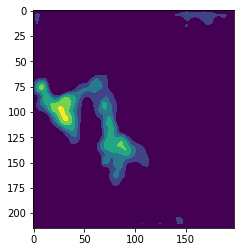

In [15]:
for file in os.listdir(folder_path):
    if fnmatch.fnmatch(file, '[0-9]*.tif'):
        converted = convert_to_heightmap_from_path(f'{folder_path}{file}')
        print(type(converted))
        imsave(f'{folder_path}converted_{file}',converted)

C:\Users\Duo\Anaconda3\envs\fastai\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


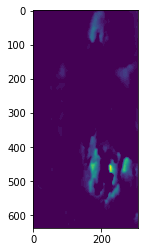

In [16]:
height_path = "I:\\Honours-Project\\data\\height_r.csv"
img = pd.read_csv(height_path, header=None).as_matrix()

pil_im = Image.fromarray(np.uint8(img))
plt.imshow(np.asarray(pil_im))     

In [17]:
def play_video(path, filename):
    cap = cv2.VideoCapture(path)

    # Check if camera opened successfully
    if (cap.isOpened()== False): 
        print("Error opening video stream or file")

    if(cap.isOpened()):
        frame_height = cap.get(CV_CAP_PROP_FRAME_HEIGHT)
        frame_width = cap.get(CV_CAP_PROP_FRAME_WIDTH)
        frame_count = cap.get(CV_CAP_PROP_FRAME_COUNT)
        fps = cap.get(CV_CAP_PROP_FPS)

        M = frame_height*frame_width

        print("Frame Count: " + str(frame_count))

    count = 0
    key_frames = []

    while(cap.isOpened()):
        ret, frame = cap.read()

        if ret == True:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            '''converted = convert_to_heightmap(frame)
            
            if converted is None:
                print("Converted is None")
                continue
            
            c_height, c_width = converted.shape
            
            if frame_height != c_height or c_width != frame_width:
                print("Converted not same size as original")
                break
            
            print(type(converted))'''

            # Display the resulting frame
            cv2.imshow('Frame',frame)

            # if(count % 14 == 0):
            if count >= 0: 
                imagePath='I:\\Honours-Project\\data\\frames\\{0}_frame{1}.tif'.format(filename, count)
                
                print("Saving image to " + imagePath)
                
                cv2.imwrite(imagePath,frame)
                key_frames.append(frame)

            # Press Q on keyboard to  exit
            if cv2.waitKey(25) & 0xFF == ord('q'):
                break
        # Break the loop
        else: 
            break

        count += 1

    # When everything done, release the video capture object
    cap.release()

    # Closes all the frames
    cv2.destroyAllWindows()

In [18]:
for path, date, flowrate in source_folders:
    for file in os.listdir(path):
        if fnmatch.fnmatch(file, '*.avi'):
            print(file)
            #play_video(f'{path}\\{file}',file)

Combined.avi
fc2_save_2018-05-15-155006-0000.avi
fc2_save_2018-05-15-155015-0000.avi
fc2_save_2018-05-15-155015-0001.avi
fc2_save_2018-05-15-152139-0000.avi
fc2_save_2018-05-15-152139-0001.avi
fc2_save_2018-05-15-161729-0000.avi
fc2_save_2018-05-15-161731-0000.avi
fc2_save_2018-05-15-161731-0001.avi
fc2_save_2018-06-01-161439-0000.avi
fc2_save_2018-06-01-141224-0000.avi
fc2_save_2018-06-01-141224-0001.avi
fc2_save_2018-06-01-133507-0000.avi
fc2_save_2018-06-01-133644-0000.avi
fc2_save_2018-06-01-133644-0001.avi
fc2_save_2018-06-05-131751-0000.avi
fc2_save_2018-06-05-131751-0001.avi
fc2_save_2018-06-05-134919-0000.avi
fc2_save_2018-06-05-134919-0001.avi
fc2_save_2018-06-05-134919-0002.avi
fc2_save_2018-06-05-143346-0000.avi
fc2_save_2018-06-05-143346-0001.avi
fc2_save_2018-06-05-143346-0002.avi
fc2_save_2018-06-06-141617-0000.avi
fc2_save_2018-06-06-141617-0001.avi
fc2_save_2018-06-06-141617-0002.avi
fc2_save_2018-06-06-131420-0000.avi
fc2_save_2018-06-06-131420-0001.avi
fc2_save_2018-0